In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import data_preprocessing.data_preprocess as dp
from scipy.stats import spearmanr
import data_preprocessing.data_loading as dl
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

In [2]:
x_var = "Opposition to Immigration"
y_var = "Welfare State"
year  = "2021"

In [3]:
x_scaled = f"{x_var} Scaled"
y_scaled = f"{y_var} Scaled"

x_vmean = f"{x_var} Voters_Mean"
y_vmean = f"{y_var} Voters_Mean"

x_comb = f"{x_var} Combined"
y_comb = f"{y_var} Combined"

In [4]:
party_scaled, voter_scaled = dp.get_scaled_party_voter_data(x_var=x_var, y_var=y_var, year="2024")

c:\Users\denid\Desktop\Case_Study_TUM25\data_preprocessing\data_loading.py:39: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)
c:\Users\denid\Desktop\Case_Study_TUM25\data_preprocessing\data_preprocess.py:43: UserWarning: Requested year '2024' not found in party data; falling back to most recent year '2021'.
  warnings.warn(f"Requested year {year!r} not found in party data; "f"falling back to most recent year {fallback!r}.", UserWarning)


In [5]:
true_df = (party_scaled[['Party_Name', x_scaled, y_scaled]].rename(columns={x_scaled:'x', y_scaled:'y'}).assign(Type='Manifesto Party position'))

mean_df = (party_scaled[['Party_Name', x_vmean, y_vmean]].rename(columns={x_vmean:'x', y_vmean:'y'}).assign(Type='Voter Mean position'))

comb_df = (party_scaled[['Party_Name', x_comb, y_comb]].rename(columns={x_comb:'x', y_comb:'y'}).assign(Type='Final party position'))

# Stack them
plot_df = pd.concat([true_df, mean_df, comb_df], ignore_index=True)

# Scatter
fig = px.scatter(plot_df, x='x', y='y', color='Party_Name', symbol='Type',
                 title=f'{x_var} vs. {y_var}: party positions (manifesto, mean, final)',
                 labels={'x':f'{x_var} (scaled)', 'y':f'{y_var} (scaled)'})

# 4) Tweak marker sizes
fig.update_traces(
    selector=dict(Type='Manifesto Party position'),
    marker=dict(size=12, symbol='circle-open')
)
fig.update_traces(
    selector=dict(Type='Voter Mean position'),
    marker=dict(size=16, symbol='x', line=dict(width=3))
)
fig.update_traces(
    selector=dict(Type='Final party position'),
    marker=dict(size=12, symbol='diamond')
)

fig.show()

In [6]:
party_scaled_df = party_scaled[['Country', 'Date', 'Calendar_Week', 'Party_Name', f"{x_var} Combined", f"{y_var} Combined", "Label"]].rename(columns={
    f'{x_var} Combined': f'{x_var} Scaled',
    f'{y_var} Combined': f'{y_var} Scaled'})

In [7]:
concatenated_df = pd.concat([voter_scaled, party_scaled_df], ignore_index=True)

fig = px.scatter(
    concatenated_df,
    x=x_scaled,
    y=y_scaled,
    color='Label',
    symbol='Label')
fig.update_traces(marker=dict(size=10))
fig.update_layout(title='Scaled Voter and Party Positions')
fig.show()

In [8]:
party_centered, voter_centered = dp.center_party_voter_data(voter_df=voter_scaled, party_df=party_scaled_df, x_var=x_var, y_var=y_var)

In [9]:
concatenated_df = pd.concat([voter_centered, party_centered], ignore_index=True)

fig = px.scatter(
    concatenated_df,
    x=f"{x_var} Centered",
    y=f"{y_var} Centered",
    color='Label',
    symbol='Label')
fig.update_traces(marker=dict(size=10))
fig.update_layout(title='Centered and Rotated Voter and Party Positions')
fig.show()

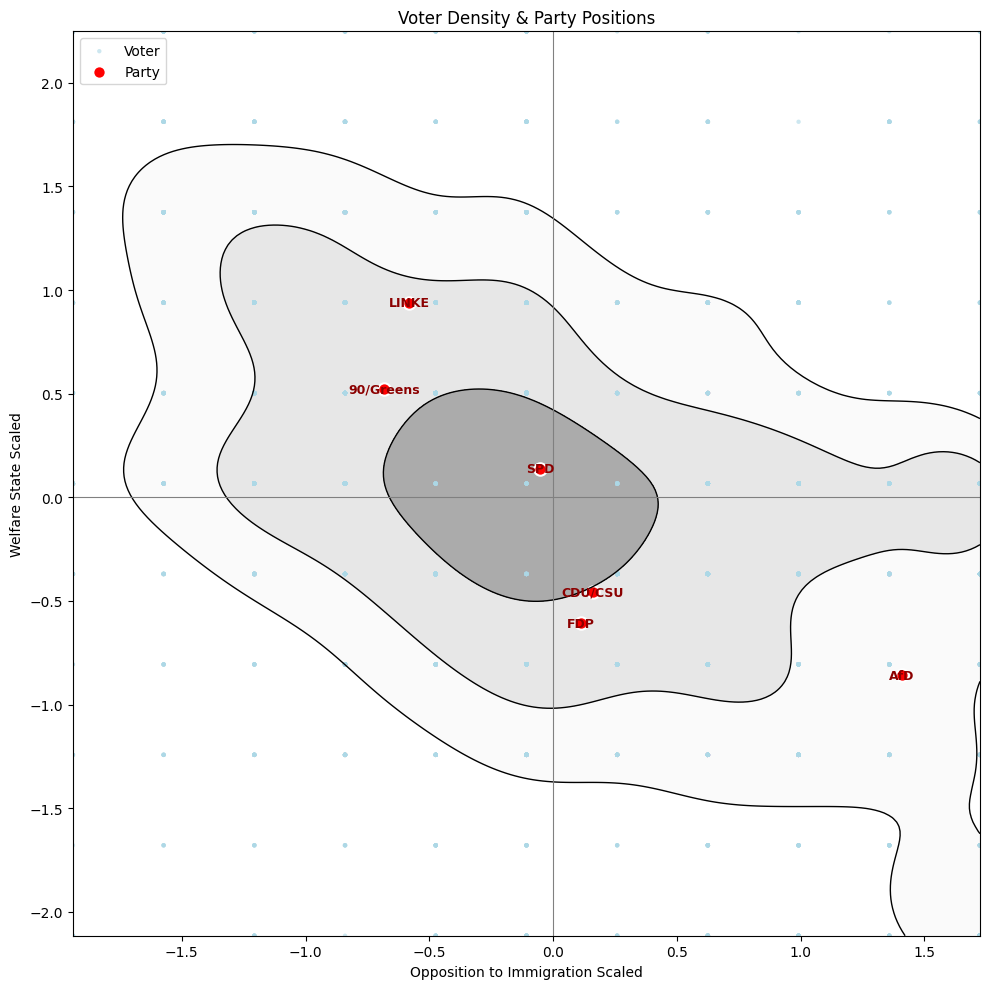

In [10]:
x_v = voter_scaled[x_scaled].values
y_v = voter_scaled[y_scaled].values

# Stack the data into a 2×N array and hand it to SciPy’s gaussian_kde
xy = np.vstack([x_v, y_v])
# In two-dimensional KDE, the data points are smoothed in both dimensions, resulting in a surface that represents the joint probability density of the two variables
kde = gaussian_kde(xy, bw_method='scott')

# You build a 200×200 grid over the observed data‐range, evaluate the estimation at each grid point, and reshape back into a 2-D array zi
nbins = 200
xi = np.linspace(x_v.min(), x_v.max(), nbins)
yi = np.linspace(y_v.min(), y_v.max(), nbins)
xi, yi = np.meshgrid(xi, yi)
zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

# surface can be visualized using contour plots, where each contour line represents a region of constant density
levels = np.percentile(zi, [50, 75, 95])

plt.figure(figsize=(10, 10))
# filled contours
plt.contourf(xi, yi, zi,
             levels=[levels[0], levels[1], levels[2], zi.max()],
             cmap="Greys",    # or any sequential colormap
             alpha=0.5)
# outline the contour levels
plt.contour(xi, yi, zi, levels=levels, colors="k", linewidths=1)

# overlay the voter points 
plt.scatter(x_v, y_v, s=10, c="lightblue", edgecolor="none", alpha=0.6, label="Voter")

# overlay the party means
px = party_scaled_df[x_scaled].values
py = party_scaled_df[y_scaled].values
labels = party_scaled_df["Party_Name"].values

plt.scatter(px, py, s=80, c="red", edgecolor="white", linewidth=1.5, label="Party")
for name, x, y in zip(labels, px, py):
    plt.text(x, y, name, fontsize=9, fontweight="bold",
             ha="center", va="center", color="darkred")

plt.axhline(0, color="grey", lw=0.8)
plt.axvline(0, color="grey", lw=0.8)
plt.xlabel(x_scaled)
plt.ylabel(y_scaled)
plt.title("Voter Density & Party Positions")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [11]:
# # plot colors for each point according to which party he voted for
# def plot(voter, party, label: bool):
#     # get party and voter positions
#     x_voter = voter[f'{x_var} Centered']
#     y_voter = voter[f'{y_var} Centered']
#     x_party = party[f'{x_var} Centered']
#     y_party = party[f'{y_var} Centered']

#     # set a color for each person depending on which party he voted for
#     color = voter["party_choice"].replace([0, 1, 2, 3, 4, 5], ["green", "red", "black", "blue", "purple", "yellow"])

#     plt.Figure()

#     plt.scatter(x_voter, y_voter, c=color, alpha=0.5)
#     plt.scatter(x_party, y_party)
#     plt.xlabel(x_var)
#     plt.ylabel(y_var)

#     # show the name of the parties
#     if "Label" in party and label:
#         label = party["Label"]
#         for x, y, text in zip(x_party, y_party, label):
#             plt.text(x, y, text)

# plot(voter_centered, party_centered, False)